# Supercar Classification

## Load and transform data

In [1]:
# Load Dependencies
import os
from PIL import Image
import numpy as np

cwd = os.getcwd()
directory = cwd + '/new_cars'
trainDir = directory + '/train'
valDir = directory + '/val'
testDir  = directory + '/test'
checkpoint_file = 'resnet50supercars.pth'
num_classes = len(os.listdir(directory + '/train'))

In [ ]:
x_train = []
for model in os.listdir(trainDir):
    for i, filename in enumerate(os.listdir(trainDir + '/' + model)):
        if i < 5:
            with Image.open(trainDir + '/' + model + '/' + filename) as image:
                x_train.append(np.asarray(image).tolist())

x_train = np.array(x_train)
print(x_train)

## Create Image Data Generators

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
batch_size = 64

train_datagen = ImageDataGenerator(
    rescale=1./255,
#     featurewise_std_normalization=True, 
#     featurewise_center=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    trainDir,
    target_size=(224,224),
    batch_size=batch_size,
    class_mode='categorical')

val_generator = train_datagen.flow_from_directory(
    valDir,
    target_size=(224,224),
    batch_size=batch_size,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    testDir,
    target_size=(224,224),
    shuffle=False,
    batch_size=batch_size,
    class_mode='categorical')

car_models = os.listdir(cwd + '/new_cars/train')

Found 6860 images belonging to 74 classes.
Found 795 images belonging to 74 classes.
Found 821 images belonging to 74 classes.


## Build Models

In [3]:
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, AveragePooling2D, Flatten, Dense, Activation, Dropout, ZeroPadding2D, Add, LeakyReLU
from tensorflow.keras import utils, Input, initializers, optimizers
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras import layers

from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomContrast, RandomWidth, RandomZoom
from tensorflow.keras.applications import ResNet50, VGG16


def bn_relu(input):
    bn = BatchNormalization(axis=3)(input)
    return Activation('relu')(bn)

def residual_block(x, downsample: bool, filters: int, kernel_size: int = 3):
    y = Conv2D(kernel_size=kernel_size, strides=(1 if not downsample else 2), filters=filters, padding='same')(x)
    y = bn_relu(y)
    y = Conv2D(kernel_size=kernel_size, strides=1, filters=filters, padding='same')(y)
    if downsample:
        x = Conv2D(kernel_size=kernel_size, strides=2, filters=filters, padding='same')(x)
    out = Add()([x,y])
    out = bn_relu(out)
    return out

def build_resnet(dropout=0.0, num_blocks_list = [2,5,5,2]):
    num_filters = 64
    X_input = Input(shape=(256,256,3))
    X = ZeroPadding2D(padding=(3,3), data_format=None)(X_input)
    X = Conv2D(filters = num_filters, kernel_size=(7,7), strides=(1,1), name = 'conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3,3), strides=(2,2))(X)
    # Stage 2 for ResNet

    for i,blocks in enumerate(num_blocks_list):
        for j in range(blocks):
            X = residual_block(X, downsample=(j==0 and i!=0), filters=num_filters)
        if num_filters < 256:
            num_filters *= 2

    x = AveragePooling2D(pool_size=(4,4), padding='same')(X)
    X = Flatten()(X)
    X = Dropout(dropout)(X)
    X = Dense(num_filters, activation='relu', kernel_initializer=glorot_uniform(seed=0))(X)
    X = Dense(num_classes, activation='softmax', name='fc' + str(num_classes), kernel_initializer=glorot_uniform(seed=0))(X)
    name = 'ResNetDropOut' + str(int(dropout * 100))
    model = Model(inputs = X_input, outputs = X, name=name)
    return model

def build_vgg_pretrained(freeze_layers=10, dropout=0.5):
    model = Sequential()
    vgg16 = VGG16(input_shape=(224,224,3), classes=num_classes, include_top=False)
    for layer in vgg16.layers[:freeze_layers]:
        layer.tranable = False
    model.add(vgg16)
    model.add(AveragePooling2D((3,3), strides=(2,2)))
    model.add(Flatten())
    model.add(Dropout(dropout))
    model.add(Dense(512, activation='relu', kernel_initializer=glorot_uniform(seed=0)))
    model.add(Dense(num_classes, activation='softmax', kernel_initializer=glorot_uniform(seed=0)))
    return model

def build_resnet_pretrained(freeze_layers=40, dropout=0.4):
    model = Sequential()
    resnet = ResNet50(input_shape=(224,224,3), classes=num_classes, include_top=False)
    print(f'This model has {len(resnet.layers)} layers')
    for layer in resnet.layers[:freeze_layers]:
        layer.tranable = False
    model.add(resnet)
    model.add(AveragePooling2D((3,3), strides=(2,2)))
    model.add(Flatten())
    model.add(Dropout(dropout))
    model.add(Dense(512, activation='relu', kernel_initializer=glorot_uniform(seed=0)))
    model.add(Dense(num_classes, activation='softmax', kernel_initializer=glorot_uniform(seed=0)))
    return model

## Build and train vgg16

In [13]:
learning_rate = 1E-5

vgg = build_vgg_pretrained()
vgg.compile(loss='categorical_crossentropy',
           optimizer=optimizers.RMSprop(lr=learning_rate * 5),
           metrics=['acc'])
vgg.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
average_pooling2d_1 (Average (None, 3, 3, 512)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 4608)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               2359808   
_________________________________________________________________
dense_3 (Dense)              (None, 74)                37962     
Total params: 17,112,458
Trainable params: 17,112,458
Non-trainable params: 0
__________________________________________

In [14]:
vgg_history = vgg.fit(train_generator,
                    steps_per_epoch=train_generator.samples/batch_size,
                    epochs=30,
                    validation_data=val_generator,
                    validation_steps=val_generator.samples/batch_size)

Epoch 1/30
107/107 [==============================] - 90s 829ms/step - loss: 4.3498 - acc: 0.0123 - val_loss: 4.2914 - val_acc: 0.0126
Epoch 2/30
107/107 [==============================] - 91s 847ms/step - loss: 4.2909 - acc: 0.0178 - val_loss: 4.2687 - val_acc: 0.0189
Epoch 3/30
107/107 [==============================] - 89s 826ms/step - loss: 4.2817 - acc: 0.0175 - val_loss: 4.2554 - val_acc: 0.0189
Epoch 4/30
107/107 [==============================] - 89s 829ms/step - loss: 4.2672 - acc: 0.0176 - val_loss: 4.2541 - val_acc: 0.0214
Epoch 5/30
107/107 [==============================] - 89s 822ms/step - loss: 4.2561 - acc: 0.0168 - val_loss: 4.2364 - val_acc: 0.0189
Epoch 6/30
107/107 [==============================] - 88s 822ms/step - loss: 4.2330 - acc: 0.0246 - val_loss: 4.2426 - val_acc: 0.0113
Epoch 7/30
107/107 [==============================] - 88s 822ms/step - loss: 4.2277 - acc: 0.0252 - val_loss: 4.1691 - val_acc: 0.0277
Epoch 8/30
107/107 [==============================] - 8

In [6]:
vgg_history = vgg.fit(train_generator,
                    steps_per_epoch=train_generator.samples/batch_size,
                    epochs=30,
                    validation_data=val_generator,
                    validation_steps=val_generator.samples/batch_size)

Epoch 1/30
 25/107 [=====>........................] - ETA: 1:02 - loss: 1.5077 - acc: 0.5856

/home/mike/anaconda3/envs/cs583/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


107/107 [==============================] - 108s 909ms/step - loss: 1.3393 - acc: 0.6172 - val_loss: 1.2185 - val_acc: 0.6591
Epoch 2/30
107/107 [==============================] - 91s 843ms/step - loss: 1.1830 - acc: 0.6478 - val_loss: 1.3536 - val_acc: 0.6352
Epoch 3/30
107/107 [==============================] - 91s 845ms/step - loss: 1.0958 - acc: 0.6735 - val_loss: 1.0245 - val_acc: 0.7069
Epoch 4/30
107/107 [==============================] - 91s 844ms/step - loss: 1.0782 - acc: 0.6739 - val_loss: 1.1709 - val_acc: 0.6642
Epoch 5/30
107/107 [==============================] - 92s 854ms/step - loss: 0.9816 - acc: 0.7090 - val_loss: 1.3753 - val_acc: 0.6478
Epoch 6/30
107/107 [==============================] - 92s 852ms/step - loss: 0.9151 - acc: 0.7179 - val_loss: 1.0147 - val_acc: 0.7094
Epoch 7/30
107/107 [==============================] - 92s 852ms/step - loss: 0.8687 - acc: 0.7335 - val_loss: 0.8954 - val_acc: 0.7220
Epoch 8/30
107/107 [==============================] - 91s 843ms/s

In [7]:
vgg_history2 = vgg.fit(train_generator,
                    steps_per_epoch=train_generator.samples/batch_size,
                    epochs=30,
                    validation_data=val_generator,
                    validation_steps=val_generator.samples/batch_size)

Epoch 1/30
107/107 [==============================] - 92s 856ms/step - loss: 0.3323 - acc: 0.9000 - val_loss: 0.5222 - val_acc: 0.8491
Epoch 2/30
107/107 [==============================] - 92s 855ms/step - loss: 0.3232 - acc: 0.8996 - val_loss: 0.5602 - val_acc: 0.8352
Epoch 3/30
107/107 [==============================] - 93s 864ms/step - loss: 0.3045 - acc: 0.9032 - val_loss: 0.7073 - val_acc: 0.8340
Epoch 4/30
107/107 [==============================] - 93s 866ms/step - loss: 0.3219 - acc: 0.9004 - val_loss: 0.6918 - val_acc: 0.7962
Epoch 5/30
107/107 [==============================] - 91s 842ms/step - loss: 0.2967 - acc: 0.9048 - val_loss: 0.5362 - val_acc: 0.8616
Epoch 6/30
107/107 [==============================] - 91s 843ms/step - loss: 0.3138 - acc: 0.9019 - val_loss: 0.6992 - val_acc: 0.8252
Epoch 7/30
107/107 [==============================] - 92s 856ms/step - loss: 0.3027 - acc: 0.9036 - val_loss: 0.5819 - val_acc: 0.8415
Epoch 8/30
107/107 [==============================] - 9

In [245]:
test_loss = vgg.evaluate(test_generator)

13/13 [==============================] - 5s 336ms/step - loss: 1.0082 - acc: 0.8063


## Save and load models and history

In [15]:
vgg.save(cwd + '/trained_models/vgg')

INFO:tensorflow:Assets written to: /home/mike/Documents/projects/supercarclass/trained_models/vgg/assets


In [296]:
vgg.save(cwd + '/trained_models/vgg90epoch')

INFO:tensorflow:Assets written to: /home/mike/Documents/projects/supercarclass/trained_models/vgg90epoch/assets


In [19]:
import json
print(type(vgg_history2.history))
json.dump(vgg_history2.history, open(cwd + '/trained_models/vgg_history2', 'w'))

<class 'dict'>


In [4]:
vgg = load_model(cwd + '/trained_models/vgg90epoch')

In [59]:
import json

with open(cwd + '/trained_models/vgg_history1') as f:
    data1 = f.read()
    
with open(cwd + '/trained_models/vgg_history2') as f:
    data2 = f.read()
    
vgg_history1 = json.loads(data1)    
vgg_history2 = json.loads(data2)

## Predict from test data

In [13]:
import re
from itertools import islice
from PIL import Image
import matplotlib.pyplot as plt

# print(test_generator.filepaths[50:55])
# print(test_generator.labels[50:55])

def get_reference_img(model):
    direct = trainDir + '/' + model
    for filename in os.listdir(direct):
        return Image.open(direct + '/' + filename)

def display_predictions(generator, num_top_predictions=5, num_images=5, offset=0, predictions_and_class=None):
    if predictions_and_class is None:
        predictions = vgg.predict(generator)
        
        predictions_and_class = []
        for i, prediction in enumerate(predictions):
            prediction = list(zip(list(test_generator.class_indices.keys()), prediction))
            prediction.sort(key = lambda p: p[1], reverse=True)
            predictions_and_class.append((generator.filepaths[i], prediction[:num_top_predictions]))

    for i, prediction in enumerate(predictions_and_class[offset:offset+num_images]):
        image_path = prediction[0]
        top_n = prediction[1]
        name = list(test_generator.class_indices.keys())[test_generator.labels[i]]
        actual_class = image_path.split('/')
        actual_class = actual_class[len(actual_class) - 2]

        y = [p[0] for p in top_n]
        x = [p[1] for p in top_n]
        image = Image.open(image_path)
        f, ax = plt.subplots(2,2,figsize = (10,6), gridspec_kw={'height_ratios': [1,1]})
        ax[0][0].imshow(image)
        ax[0][0].set_title(actual_class)
        ax[0][0].axis('off')
        ax[0][1].barh(y, x)
        ax[0][1].set_yticks(np.arange(len(y)))
        ax[0][1].set_yticklabels(y)
        ax[0][1].invert_yaxis() 
        ax[1][0].imshow(get_reference_img(y[0]))
        ax[1][0].set_title(y[0])
        ax[1][0].axis('off')
        ax[1][1].imshow(get_reference_img(y[1]))
        ax[1][1].set_title(y[1])
        ax[1][1].axis('off')

        plt.tight_layout()
        plt.savefig(f'images/{actual_class}.png')
        plt.show()
    return predictions_and_class

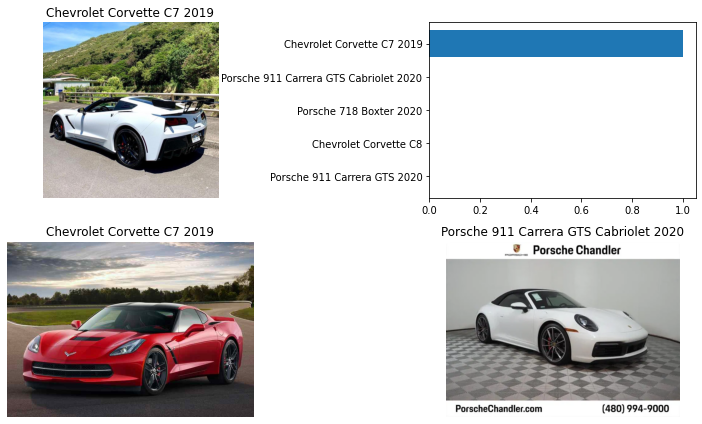

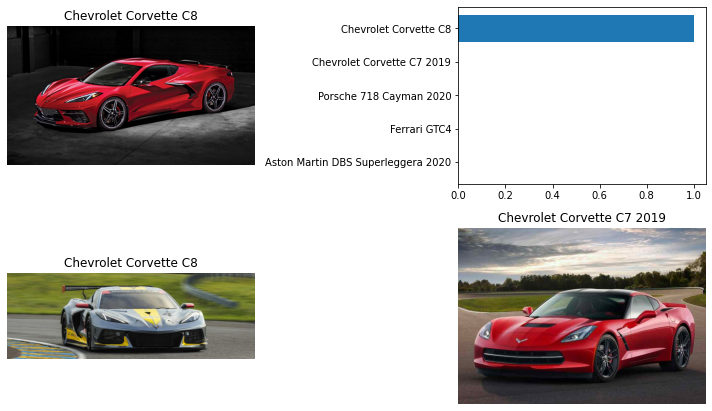

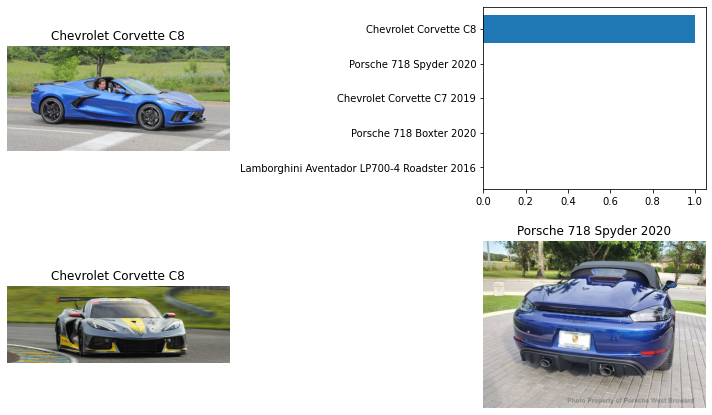

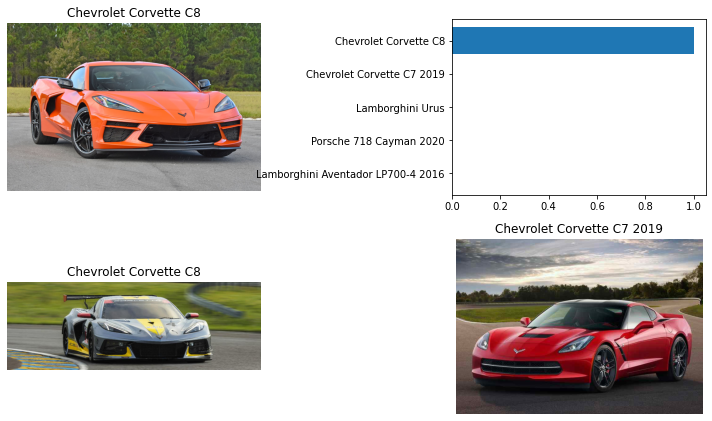

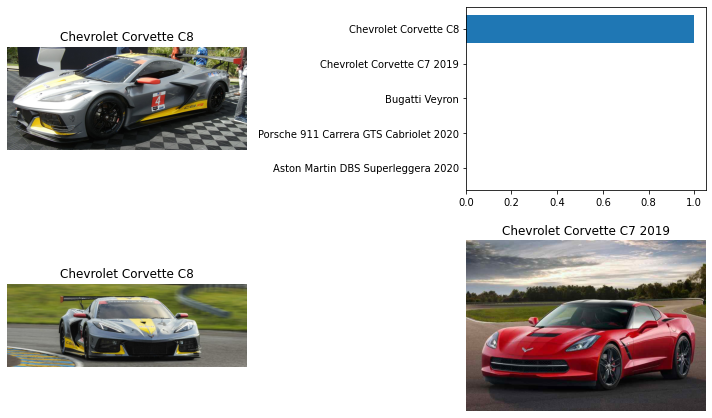

In [14]:
top_predictions = display_predictions(test_generator, offset=100)

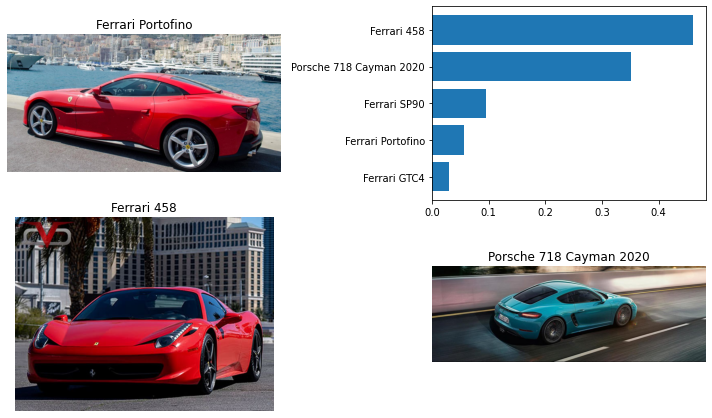

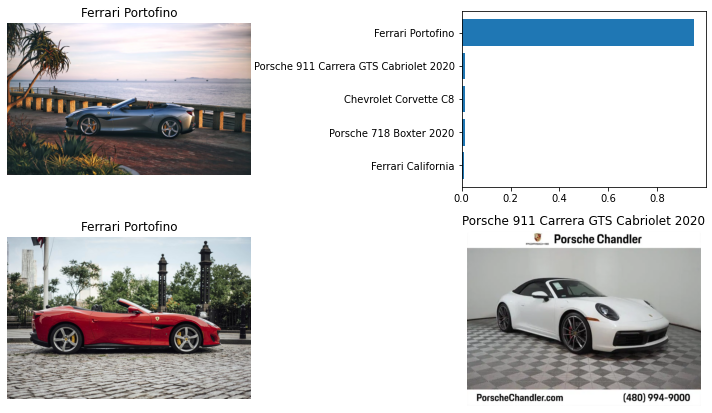

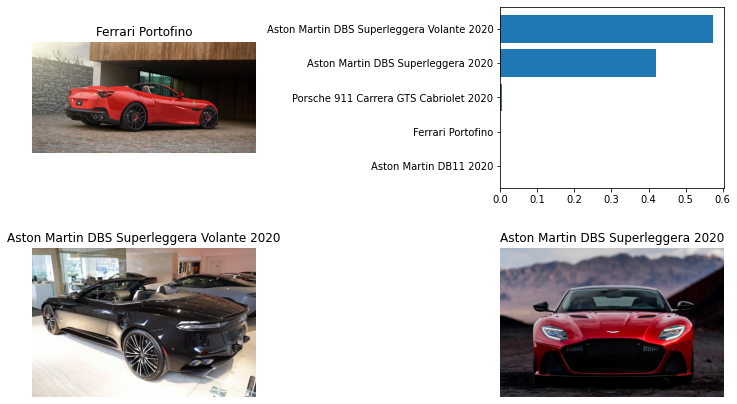

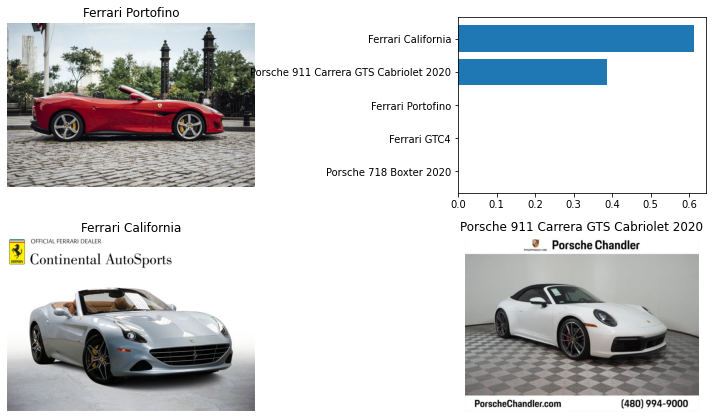

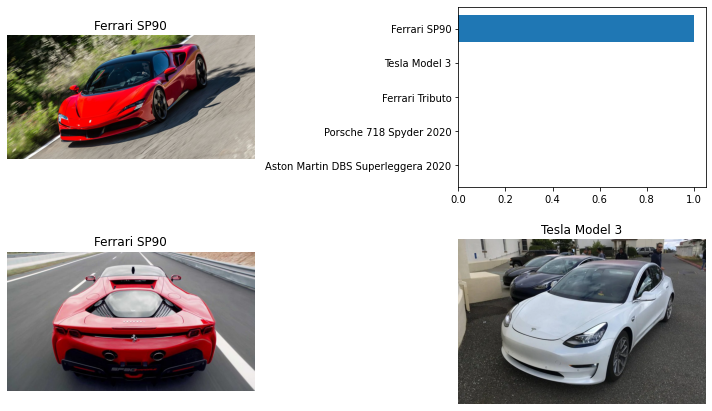

[('/home/mike/Documents/projects/supercarclass/new_cars/test/Aston Martin DB11 2020/12206.jpg',
  [('Bugatti Veyron', 0.5603644),
   ('McLaren GT', 0.13522258),
   ('Bugatti Chiron', 0.1287347),
   ('McLaren 570GT', 0.10352698),
   ('Tesla Model S', 0.028368505)]),
 ('/home/mike/Documents/projects/supercarclass/new_cars/test/Aston Martin DB11 2020/12211.jpg',
  [('Aston Martin DB11 Volante 2020', 0.9445099),
   ('Bugatti Centodieci', 0.041191924),
   ('Aston Martin DB11 2020', 0.012089386),
   ('Aston Martin DBS Superleggera Volante 2020', 0.0012784227),
   ('Lamborghini Huracan LP610-4 Spyder 2019', 0.0002688242)]),
 ('/home/mike/Documents/projects/supercarclass/new_cars/test/Aston Martin DB11 2020/12217.jpg',
  [('Aston Martin DB11 Volante 2020', 0.99874485),
   ('Ferrari California', 0.0007481969),
   ('Aston Martin DB11 2020', 0.00042003032),
   ('Aston Martin DBS Superleggera Volante 2020', 6.5526394e-05),
   ('Porsche 911 Carrera GTS Cabriolet 2020', 1.02956865e-05)]),
 ('/home/m

In [17]:
display_predictions(test_generator, offset=250, predictions_and_class=top_predictions)

## Results

In [294]:
import matplotlib.pyplot as plt

def plot_history(name, *args):
    base = args[0].copy()
    for arg in args[1:]:
        base['loss'] = base['loss'] + arg['loss']
        base['acc'] = base['acc'] + arg['acc']
        base['val_loss'] = base['val_loss'] + arg['val_loss']
        base['val_acc'] = base['val_acc'] + arg['val_acc']
    
    x = [i + 30 for i in range(0, len(base['acc']))]
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy over Epochs for {name}')
    plt.plot(x, base['acc'], 'b-', label='Train')
    plt.plot(x, base['val_acc'], 'r-', label='Validation')
    plt.legend()
    plt.savefig(f'images/{name}_plot.png')
    plt.savefig(f'images/{name}_plot.pdf')
    plt.show()

In [23]:
temp = np.array([1,2,3,4,5])
np.linalg.norm(np.tanh(temp), ord=2)

2.1208456479558806

In [19]:
import math
math.sqrt(55)

7.416198487095663

In [25]:
50*70 + 50

3550

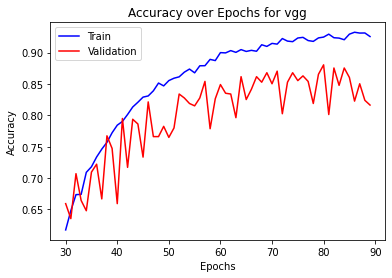

In [295]:
plot_history('vgg', vgg_history1, vgg_history2)